# Multi Qubit Systems



In [1]:
# Importing packages for this notebook.

from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import math

# Setting up the background.

token = ''
shots = 100_000

service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.least_busy(simulator=False, operational=True)

## Qubits on Stack

We have seen that $\ket{0} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$ and $\ket{1} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$.
What happens if we expand this idea to multiple qubits?
We can describe multi qubit systems using tensor products ($\otimes$).

$$
\begin{align*}
    \begin{bmatrix} a_1 \\ a_2 \\ \vdots \\ a_n \end{bmatrix} \otimes \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_m \end{bmatrix} &= \begin{bmatrix} a_1 \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_m \end{bmatrix} \\ a_2 \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_m \end{bmatrix} \\ \vdots \\ a_n \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_m \end{bmatrix} \end{bmatrix} = \begin{bmatrix} a_1b_1 \\ a_1b_2 \\ \vdots \\ a_1b_m \\ a_2b_1 \\ a_2b_2 \\ \vdots \\ a_2b_m \\ \vdots \\ a_nb_1 \\ a_nb_2 \\ \vdots \\ a_nb_m \end{bmatrix}
\end{align*}
$$

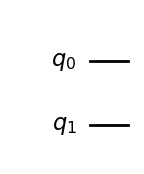

In [2]:
qc = QuantumCircuit(2)
qc.draw('mpl')

As you can see above, we cann see that we are using two qubits on this quantum circuit.
Using the tensor product, we can describe the state of multiple qubits simultaneously.

$$
\begin{align*}
    \ket{0} \otimes \ket{0} &= \begin{bmatrix} 1 \\ 0 \end{bmatrix} \otimes \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} 1 \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\ 0 \begin{bmatrix} 1 \\ 0 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix} = \ket{00} \\
    \ket{0} \otimes \ket{1} &= \begin{bmatrix} 1 \\ 0 \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 1 \end{bmatrix} = \begin{bmatrix} 1 \begin{bmatrix} 0 \\ 1 \end{bmatrix} \\ 0 \begin{bmatrix} 0 \\ 1 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \end{bmatrix} = \ket{01} \\
    \ket{1} \otimes \ket{0} &= \begin{bmatrix} 0 \\ 1 \end{bmatrix} \otimes \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} 0 \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\ 1 \begin{bmatrix} 1 \\ 0 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} = \ket{10} \\
    \ket{1} \otimes \ket{1} &= \begin{bmatrix} 0 \\ 1 \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 1 \end{bmatrix} = \begin{bmatrix} 0 \begin{bmatrix} 0 \\ 1 \end{bmatrix} \\ 1 \begin{bmatrix} 0 \\ 1 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix} = \ket{11}
\end{align*}
$$

What about a three qubit system?

$$
\begin{align*}
    \ket{00} \otimes \ket{0} &= \ket{000} \\
    \ket{00} \otimes \ket{1} &= \ket{001} \\
    \ket{01} \otimes \ket{0} &= \ket{010} \\
    \ket{01} \otimes \ket{1} &= \ket{011} \\
    \ket{10} \otimes \ket{0} &= \ket{100} \\
    \ket{10} \otimes \ket{1} &= \ket{101} \\
    \ket{11} \otimes \ket{0} &= \ket{110} \\
    \ket{11} \otimes \ket{1} &= \ket{111}
\end{align*}
$$

We can observe two important patterns here:
1. We can always append a new qubit using tensor product, and
2. If you want to represent $\ket{n}$ in matrix form, the $(n+1)$-th entry is $1$, and all other entries are $0$.

It should naturally follow that quantum gates on the multiple qubit system should use tensor products.

## Gates on Stack

Tensor products on matrices work in a similar way.

$$
\begin{align*}
    \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix} \otimes \begin{bmatrix} b_{11} & b_{12} \\ b_{21} & b_{22} \end{bmatrix} &= \begin{bmatrix} a_{11} \begin{bmatrix} b_{11} & b_{12} \\ b_{21} & b_{22} \end{bmatrix} & a_{12} \begin{bmatrix} b_{11} & b_{12} \\ b_{21} & b_{22} \end{bmatrix} \\ a_{21} \begin{bmatrix} b_{11} & b_{12} \\ b_{21} & b_{22} \end{bmatrix} & a_{22} \begin{bmatrix} b_{11} & b_{12} \\ b_{21} & b_{22} \end{bmatrix} \end{bmatrix} = 
    \begin{bmatrix} 
        a_{11}b_{11} & a_{11}b_{12} & a_{12}b_{11} & a_{12}b_{12} \\ 
        a_{11}b_{21} & a_{11}b_{22} & a_{12}b_{21} & a_{12}b_{22} \\
        a_{21}b_{11} & a_{21}b_{12} & a_{22}b_{11} & a_{22}b_{12} \\
        a_{21}b_{21} & a_{21}b_{22} & a_{22}b_{21} & a_{22}b_{22}
    \end{bmatrix}
\end{align*}
$$

Note that a matrix created by the tensor product of two unitary matrices is also unitary, so $(U_1 \otimes U_2)^{-1} = U_1^\dagger \otimes U_2^\dagger$ and $(U_1 \otimes U_2)^\dagger = U_1^\dagger \otimes U_2^\dagger$ hold.

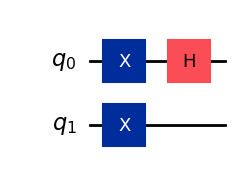

In [3]:
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.h(0)
qc.draw('mpl')

Now, let us find the matrix form of the circuit above.

$$
\begin{align*}
    X \otimes X &= \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \otimes \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \\
    &= 
    \begin{bmatrix} 
        0 & 0 & 0 & 1 \\
        0 & 0 & 1 & 0 \\
        0 & 1 & 0 & 0 \\
        1 & 0 & 0 & 0
    \end{bmatrix} \\
    H \otimes I &= \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \otimes \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \\
    &= \frac{1}{\sqrt{2}}
    \begin{bmatrix}
        1 & 0 & 1 & 0 \\
        0 & 1 & 0 & 1 \\
        1 & 0 & -1 & 0 \\
        0 & 1 & 0 & -1
    \end{bmatrix} \\
    (H \otimes I)(X \otimes X) &= \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1 \end{bmatrix} \begin{bmatrix} 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\  1 & 0 & 0 & 0 \end{bmatrix} \\
    &= \frac{1}{\sqrt{2}}
    \begin{bmatrix}
        0 & 1 & 0 & 1 \\
        1 & 0 & 1 & 0 \\
        0 & -1 & 0 & 1 \\
        -1 & 0 & 1 & 0
    \end{bmatrix}
\end{align*}
$$

To compute the overall state after this gate, we just need to compute $\ket{\psi_f} = (H \otimes I)(X \otimes X)\ket{\psi_i}$.
What would we get by passing $\ket{0}$ to this gate?
We apply NOT gates to both qubits, followed by a Hadamard gate on the first qubit.
By direct manipulation, we expect to get $\ket{\psi_f} = \ket{-} \otimes \ket{1} = (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) \otimes \ket{1} = \frac{1}{\sqrt{2}}\ket{01} - \frac{1}{\sqrt{2}}\ket{11}$.
Let us verify this using matrix multiplication:

$$
\begin{align*}
    \ket{\psi_f} &= (H \otimes I)(X \otimes X)\ket{00} \\
    &= \frac{1}{\sqrt{2}} \begin{bmatrix} 0 & 1 & 0 & 1 \\ 1 & 0 & 1 & 0 \\ 0 & -1 & 0 & 1 \\ -1 & 0 & 1 & 0 \end{bmatrix} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix} \\
    &= \frac{1}{\sqrt{2}} \begin{bmatrix} 0 \\ 1 \\ 0 \\ -1 \end{bmatrix} \\
    &= \frac{1}{\sqrt{2}} \left(\begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \end{bmatrix} - \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}\right) \\
    &= \frac{1}{\sqrt{2}} (\ket{01} - \ket{11}) \\
    &= \frac{1}{\sqrt{2}}\ket{01} - \frac{1}{\sqrt{2}}\ket{11} \text{.}
\end{align*}
$$

We got the anticipated result.
Please note that to be a valid quantum state, no matter it is a single-qubit or multi-qubit system, the probability must add up to $1$; that is, $\sum_{i=0}^{2^n-1} |a_i|^2 = 1$.

To sum up what we covered so far:
1. When the quantum gates are connected *horizontally*, we use *matrix multiplication*, and
2. When the quantum gates are connected *vertically*, we use *tensor product*.

### Complexity

We can quickly demonstrate that as we append one qubit at a time, the vectors and matrices we need to manipulate grow exponentially.
Here, vectors representing the qubit state grow at a rate of $O(2^n)$ ($2^n$ entries), and matrices that represents the quantum gates grow in a rate of $O(2^{2n})$ ($2^n \times 2^n$ matrix).
Suppose we are using `float` data type (4 bytes) to represent a number.
Since the probability amplitudes are complex, we must use 8 bytes (4 bytes for the real part and 4 bytes for the imaginary part) to represent a single entry in a quantum gate matrix.
To simulate a 5-qubit system, we can prepare a memory device with $8 \times 2^{2(5)} = 8192$ bytes, but to simulate a 50-qubit system, we must have at least $8 \times 2^{2(50)} \approx 1.014 \times 10^{31}$ bytes.
This is why it is so hard to simulate quantum computing in a classical computer.

### CNOT Gate

A CNOT gate has two parts: control and target.
If we put a CNOT gate in a way that qubit $a$ is the control and qubit $b$ is the target, we can notate it as $\text{CNOT}_{(a, b)}$.
A NOT (Pauli-X) gate is applied if and only if the control is $\ket{1}$.
Thus, without using matrices, we can derive the following:

$$
\begin{align*}
    \text{CNOT}_{(1, 2)} \ket{00} &= \ket{00} \text{, } \\
    \text{CNOT}_{(1, 2)} \ket{01} &= \ket{01} \text{, } \\
    \text{CNOT}_{(1, 2)} \ket{10} &= \ket{11} \text{, and } \\
    \text{CNOT}_{(1, 2)} \ket{11} &= \ket{10} \text{.}
\end{align*}
$$

And the matrix form of a CNOT gate is:

$$
\begin{align*}
    \text{CNOT}_{(1, 2)} = 
    \begin{bmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 \\
        0 & 0 & 1 & 0
    \end{bmatrix} \text{.}
\end{align*}
$$

We can create an if-statement equivalent in quantum computers using this gate.

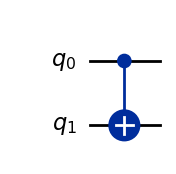

In [4]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.draw('mpl')

### SWAP Gate

A SWAP gate swaps the quantum states of two different qubits instantly, such that $\text{SWAP} (\ket{\psi_1} \otimes \ket{\psi_2}) = \ket{\psi_2} \otimes \ket{\psi_1}$.
We can easily construct a SWAP gate using three CNOT gates.

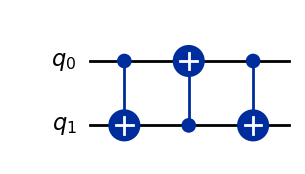

In [5]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.cx(1, 0)
qc.cx(0, 1)
qc.draw('mpl')

We can easily verify this works by direct manipulation.
Let $\ket{\psi_1} = \alpha\ket{0} + \beta\ket{1}$ and $\ket{\psi_2} = \gamma\ket{0} + \delta\ket{1}$.
Then we have the following:

$$
\begin{align*}
    \text{SWAP} (\ket{\psi_1} \otimes \ket{\psi_2}) &= \text{CNOT}_{(1, 2)}\text{CNOT}_{(2, 1)}\text{CNOT}_{(1, 2)} (\ket{\psi_1} \otimes \ket{\psi_2}) \\
    &= \text{CNOT}_{(1, 2)}\text{CNOT}_{(2, 1)}\text{CNOT}_{(1, 2)} ((\alpha\ket{0} + \beta\ket{1}) \otimes (\gamma\ket{0} + \delta\ket{1})) \\
    &= \text{CNOT}_{(1, 2)}\text{CNOT}_{(2, 1)}\text{CNOT}_{(1, 2)} (\alpha\gamma\ket{00} + \alpha\delta\ket{01} + \beta\gamma\ket{10} + \beta\delta\ket{11}) \\
    &= \text{CNOT}_{(1, 2)}\text{CNOT}_{(2, 1)} (\alpha\gamma\ket{00} + \alpha\delta\ket{01} + \beta\gamma\ket{11} + \beta\delta\ket{10}) \\
    &= \text{CNOT}_{(1, 2)} (\alpha\gamma\ket{00} + \alpha\delta\ket{11} + \beta\gamma\ket{01} + \beta\delta\ket{10}) \\
    &= \alpha\gamma\ket{00} + \alpha\delta\ket{10} + \beta\gamma\ket{01} + \beta\delta\ket{11} \\
    &= (\gamma\ket{0} + \delta\ket{1}) \otimes (\alpha\ket{0} \otimes \beta\ket{1}) \\
    &= \ket{\psi_2} \otimes \ket{\psi_1} \text{.}
\end{align*}
$$

This result is particularly useful because when working with two or more qubit systems and the real quantum computer does not support the current placement of the qubits, we can apply SWAP gates several times to change the qubit placement.

### Toffoli Gate

A Toffoli gate accepts two control qubits and one target qubit.
It applies a NOT gate to the target gate if and only if both controlled qubits are $\ket{1}$.
We can create an AND gate equivalent in quantum computers using this gate.

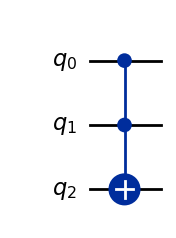

In [6]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.draw('mpl')

### Other Controlled Gates

In fact, we can generalize the matrix form of CNOT gates by: 

$$
\begin{align*}
    \text{CU}_{(1, 2)} = 
    \begin{bmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & u_{11} & u_{12} \\
        0 & 0 & u_{21} & u_{22}
    \end{bmatrix} \text{, }
\end{align*}
$$

where the entries with $u$ stand for the matrix of any one-qubit quantum gates.
Just like CNOT gates, we can compute the state applying these gates without any matrix.

$$
\begin{align*}
    \text{CU}_{(1, 2)} \ket{00} &= \ket{0} \otimes \ket{0} \\
    \text{CU}_{(1, 2)} \ket{01} &= \ket{0} \otimes \ket{1} \\
    \text{CU}_{(1, 2)} \ket{10} &= \ket{1} \otimes U\ket{0} \\
    \text{CU}_{(1, 2)} \ket{11} &= \ket{1} \otimes U\ket{1} \\
\end{align*}
$$

## No-Cloning Theorem

It turns out that ***we cannot copy the quantum state of a qubit to another qubit using quantum gates***.
The proof is the following.

**Proof**: Suppose there were a quantum gate $U$ operates such that $U(\ket{\psi} \otimes \ket{0}) = \ket{\psi} \otimes \ket{\psi}$ and let $\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00}+\ket{01})$.
By linearity, we obtain the following:

$$
\begin{align*}
    U(\ket{\psi} \otimes \ket{0}) &= U\left(\frac{1}{\sqrt{2}}(\ket{00}+\ket{10})\right) \\
    &= \frac{1}{\sqrt{2}}(U\ket{00}+U\ket{10}) \\
    &= \frac{1}{\sqrt{2}}(\ket{00}+\ket{11}) \text{.}
\end{align*}
$$

Note that we can factor out entrailing $\ket{0}$ in $\ket{\psi}$ such that:

$$
\begin{align*}
    \ket{\psi} &= \frac{1}{\sqrt{2}}(\ket{00}+\ket{10}) = \frac{\ket{0}+\ket{1}}{\sqrt{2}} \otimes \ket{0} \text{.}
\end{align*}
$$

Now, applying $U$ gate gives us:

$$
\begin{align*}
    U(\ket{\psi} \otimes \ket{0}) &= U \left(\frac{\ket{0}+\ket{1}}{\sqrt{2}} \otimes \ket{0}\right) \\
    &= \frac{\ket{0}+\ket{1}}{\sqrt{2}} \otimes \frac{\ket{0}+\ket{1}}{\sqrt{2}} \\
    &= \frac{1}{2} (\ket{00} + \ket{01} + \ket{10} + \ket{11}) \text{.}
\end{align*}
$$

Since we obtained the fact that $\frac{1}{\sqrt{2}}(\ket{00}+\ket{11}) \neq \frac{1}{2} (\ket{00} + \ket{01} + \ket{10} + \ket{11})$, this contradicts our previous assumption, and thus there is no such $U$.

This is called the **no-cloning theorem**, which states that a unitary copy gate cannot exist (quantum computers cannot do quantum copy).
It feels ironic that quantum computers cannot handle a simple operation like copying, which classical computers can do without any problem.
On the other hand, we can entangle the qubits instead.
When qubits are entangled, once a quantum gate changes the quantum state of one qubit, the other qubit's state is changes according to the quantum gate that was applied to the first qubit, instantly (even faster than the speed of light!).

## Entanglement

A **product state** is a quantum state that can be rewritten as a tensor product of two quantum states.
For instance, a quantum state $\ket{\psi} = \frac{1}{2}(\ket{00} + \ket{01} + \ket{10} + \ket{11})$ is a product state because we can rewrite this as $\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \otimes \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$.

Meanwhile, an **entangled** state is a quantum state that is not a product state.
For instance, a quantum state $\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})$ is entangled.
Notice, since we cannot 'separate' this quantum state into two different quantum states, even if we 'apply' a quantum gate to one of these entangled qubits, the quantum gate is applied to the other entangled qubit as well.
As mentioned above, we can manipulate entangled qubits instantly even though those two qubits are light-years apart (*"Spooky action at a distance."*).
We can easily entangle qubits by using Hadamard and CNOT gates.

### Bell State

A Bell state is a type of entangled quantum state. 
We can easily create one by applying $\text{CNOT}_{(1, 2)} (H \otimes I)$.
$$
\begin{align*}
    \text{CNOT}_{(1, 2)} (H \otimes I) \ket{00} &= \text{CNOT}_{(1, 2)} \left(\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{10}\right) \\
    &= \frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11} \\
    &= \frac{1}{\sqrt{2}}(\ket{00} + \ket{11}) = \ket{\Phi^+}
\end{align*}
$$
There are other combinations of Bell states such as $\ket{\Phi^-} = \frac{1}{\sqrt{2}}(\ket{00} - \ket{11})$, $\ket{\Psi^+} = \frac{1}{\sqrt{2}}(\ket{01} + \ket{10})$, and $\ket{\Psi^-} = \frac{1}{\sqrt{2}}(\ket{01} - \ket{10})$.
They can be created with an extra help from NOT gates.

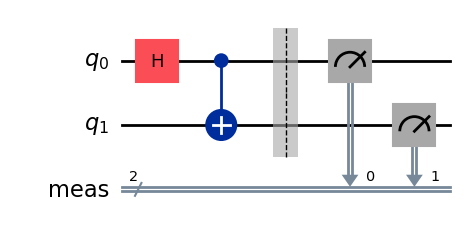

In [7]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw('mpl')

In [8]:
# Transpiling the circuit.

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
trans_qc = pm.run(qc)

# Sending a job.

sampler = Sampler(mode=backend)
job = sampler.run([trans_qc], shots=shots)

# Printing the result.

result = job.result()
bit_str_dict = result[0].data.meas.get_counts()

for bit_str in bit_str_dict:
    print(f"{bit_str}: {bit_str_dict[bit_str]}")

11: 49227
00: 49317
10: 663
01: 793


### GHZ State

This is essentially the three-qubit version of a Bell state.
We can create one by applying $(I \otimes \text{CNOT}_{(2, 3)}) (\text{CNOT}_{(1, 2)} \otimes I) (H \otimes I \otimes I)$.
$$
\begin{align*}
    \text{CNOT}_{(2, 3)} \text{CNOT}_{(1, 2)} (H \otimes I \otimes I) \ket{000} &= \text{CNOT}_{(2, 3)} \text{CNOT}_{(1, 2)} \left(\frac{1}{\sqrt{2}}\ket{000} + \frac{1}{\sqrt{2}}(\ket{100})\right) \\
    &= \text{CNOT}_{(2, 3)} \left(\frac{1}{\sqrt{2}}\ket{000} + \frac{1}{\sqrt{2}}(\ket{110})\right) \\
    &= \frac{1}{\sqrt{2}}\ket{000} + \frac{1}{\sqrt{2}}\ket{111} \\
    &= \frac{1}{\sqrt{2}} (\ket{000} + \ket{111}) = \ket{\text{GHZ}}
\end{align*}
$$
We can entangle even more qubits in this manner.

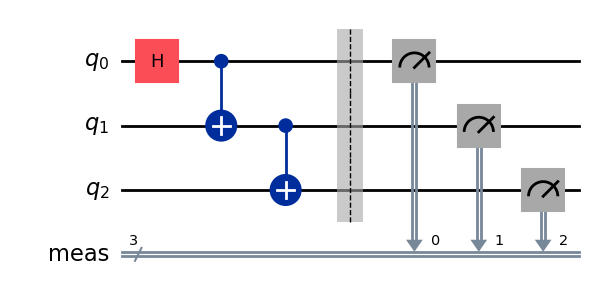

In [9]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()
qc.draw('mpl')

In [10]:
# Transpiling the circuit.

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
trans_qc = pm.run(qc)

# Sending a job.

sampler = Sampler(mode=backend)
job = sampler.run([trans_qc], shots=shots)

# Printing the result.

result = job.result()
bit_str_dict = result[0].data.meas.get_counts()

for bit_str in bit_str_dict:
    print(f"{bit_str}: {bit_str_dict[bit_str]}")

011: 430
111: 48758
000: 48262
001: 711
010: 247
100: 665
101: 482
110: 445


### W State

We can create this state by applying $(X \otimes I \otimes I) (\text{CNOT}_{(1, 2)} \otimes I) (I \otimes \text{CNOT}_{(2, 3)}) (\text{CH}_{(1, 2)} \otimes I) (R_Y(\theta) \otimes I \otimes I)$, where $R_Y(\theta) = \begin{bmatrix} \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\ \sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2}) \end{bmatrix}$ and $\theta = 2\arccos(\frac{1}{\sqrt{3}})$.

$$
\begin{align*}
    &(X \otimes I \otimes I) (\text{CNOT}_{(1, 2)} \otimes I) (I \otimes \text{CNOT}_{(2, 3)}) (\text{CH}_{(1, 2)} \otimes I) (R_Y(\theta) \otimes I \otimes I) \ket{000} \\
    &= (X \otimes I \otimes I) (\text{CNOT}_{(1, 2)} \otimes I) (I \otimes \text{CNOT}_{(2, 3)}) (\text{CH}_{(1, 2)} \otimes I) \left(\begin{bmatrix} \cos\left(\frac{\theta}{2}\right) \\ \sin\left(\frac{\theta}{2}\right) \end{bmatrix} \otimes \ket{00}\right) \\
    &= (X \otimes I \otimes I) (\text{CNOT}_{(1, 2)} \otimes I) (I \otimes \text{CNOT}_{(2, 3)}) (\text{CH}_{(1, 2)} \otimes I) \left(\left(\cos\left(\frac{\theta}{2}\right)\ket{0} + \sin\left(\frac{\theta}{2}\right)\ket{1}\right) \otimes \ket{00}\right) \\
    &= (X \otimes I \otimes I) (\text{CNOT}_{(1, 2)} \otimes I) (I \otimes \text{CNOT}_{(2, 3)}) (\text{CH}_{(1, 2)} \otimes I) \left(\cos\left(\frac{\theta}{2}\right)\ket{000} + \sin\left(\frac{\theta}{2}\right)\ket{100}\right) \\
    &= (X \otimes I \otimes I) (\text{CNOT}_{(1, 2)} \otimes I) (I \otimes \text{CNOT}_{(2, 3)}) \left(\cos\left(\frac{\theta}{2}\right)\ket{000} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{100} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{110}\right) \\
    &= (X \otimes I \otimes I) (\text{CNOT}_{(1, 2)} \otimes I) \left(\cos\left(\frac{\theta}{2}\right)\ket{000} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{100} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{111}\right) \\
    &= (X \otimes I \otimes I) \left(\cos\left(\frac{\theta}{2}\right)\ket{000} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{110} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{101}\right) \\
    &= \cos\left(\frac{\theta}{2}\right)\ket{100} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{010} + \frac{1}{\sqrt{2}}\sin\left(\frac{\theta}{2}\right)\ket{001} \\
    &= \cos\left(\frac{2\arccos\left(\frac{1}{\sqrt{3}}\right)}{2}\right)\ket{100} + \frac{1}{\sqrt{2}}\sin\left(\frac{2\arccos\left(\frac{1}{\sqrt{3}}\right)}{2}\right)\ket{010} + \frac{1}{\sqrt{2}}\sin\left(\frac{2\arccos\left(\frac{1}{\sqrt{3}}\right)}{2}\right)\ket{001} \\
    &= \frac{1}{\sqrt{3}}\ket{100} + \frac{1}{\sqrt{2}}\sqrt{\frac{2}{3}}\ket{010} + \frac{1}{\sqrt{2}}\sqrt{\frac{2}{3}}\ket{001} \\
    &= \frac{1}{\sqrt{3}}\ket{100} + \frac{1}{\sqrt{3}}\ket{010} + \frac{1}{\sqrt{3}}\ket{001} \\
    &= \frac{1}{\sqrt{3}} (\ket{100} + \ket{010} +\ket{001}) = \ket{\text{W}}
\end{align*}
$$

Just like other entangled qubit states, we can see that the W state cannot be separated into a tensor product of two qubit states.
We can generalize this state to $n$ qubits: $\ket{\text{W}} = \frac{1}{\sqrt{n}}(\ket{100 \cdots 00} + \ket{010 \cdots 00} + \ket{001 \cdots 00} + \cdots + \ket{000 \cdots 10} + \ket{000 \cdots 01})$.

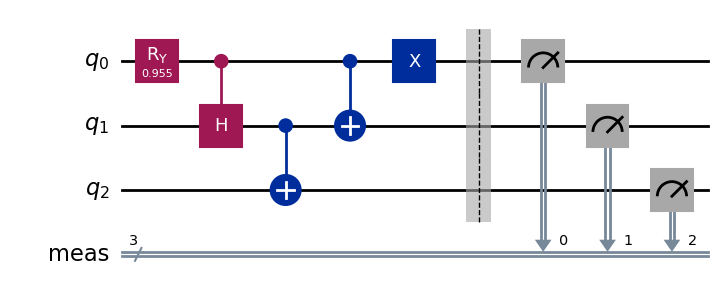

In [11]:
theta = math.acos(1.0 / math.sqrt(3))

qc = QuantumCircuit(3)
qc.ry(theta, 0)
qc.ch(0, 1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.x(0)
qc.measure_all()
qc.draw('mpl')

In [12]:
# Transpiling the circuit.

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
trans_qc = pm.run(qc)

# Sending a job.

sampler = Sampler(mode=backend)
job = sampler.run([trans_qc], shots=shots)

# Printing the result.

result = job.result()
bit_str_dict = result[0].data.meas.get_counts()

for bit_str in bit_str_dict:
    print(f"{bit_str}: {bit_str_dict[bit_str]}")

110: 388
001: 73752
010: 11117
101: 2170
100: 10820
000: 680
111: 442
011: 631


### Entanglement With More Qubits

Let us entangle ten qubits and observe the results.

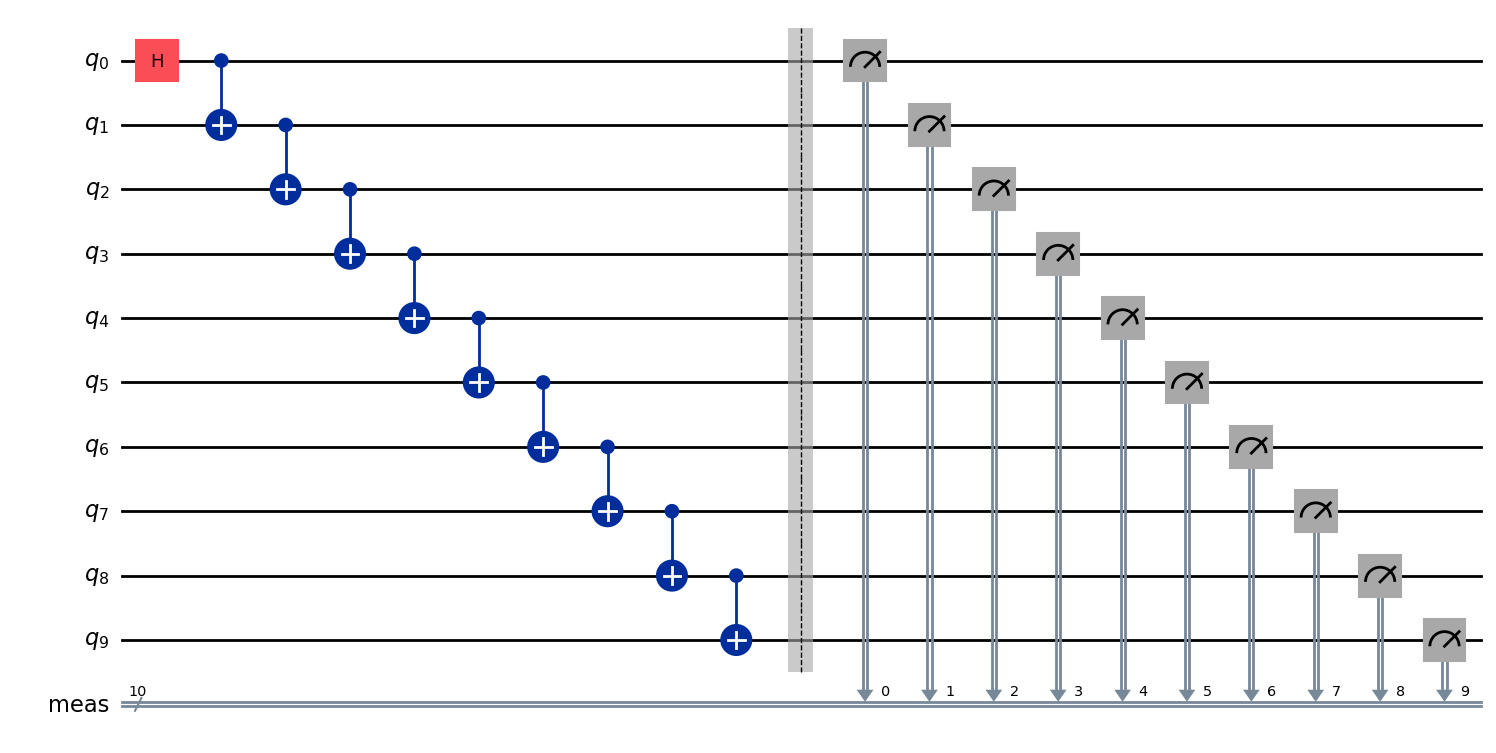

In [13]:
qc = QuantumCircuit(10)
qc.h(0)
for i in range(10-1):
    qc.cx(i, i+1)
qc.measure_all()
qc.draw('mpl')

As we entangled 10 qubits in this way, the final state $\ket{\psi}$ right before measuring must be:
$$
\begin{align*}
    \ket{\psi} = \frac{\ket{0000000000} + \ket{1111111111}}{\sqrt{2}} \text{, }
\end{align*}
$$
which implies that we are supposed to get `0000000000` with 50% chance and `1111111111` with 50% chance.

In [14]:
# Transpiling the circuit.

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
trans_qc = pm.run(qc)

# Sending a job.

sampler = Sampler(mode=backend)
job = sampler.run([trans_qc], shots=shots)

# Printing the result.

result = job.result()
bit_str_dict = result[0].data.meas.get_counts()

for bit_str in bit_str_dict:
    print(f"{bit_str}: {bit_str_dict[bit_str]}")

1011101111: 2
1111111111: 22647
0000000110: 14305
0000000010: 8735
0001000000: 526
1111111101: 7843
1111111010: 4052
0111111010: 197
1110111101: 193
0000001010: 662
1111111011: 6932
0000100010: 147
0001000010: 1838
1111111001: 4499
0000100110: 234
0001000100: 469
0001000111: 160
0111111001: 201
0011111110: 10
1111111110: 1484
0011111101: 53
0111111101: 393
0001000110: 3117
0111111011: 333
0100000110: 873
0000000000: 2364
1111101111: 148
0001001010: 119
1111110111: 353
1111111000: 523
0000000011: 657
0100001010: 32
0111000111: 1
0010000010: 65
0100000010: 524
0000001110: 441
0011111111: 162
1111101011: 40
0000000100: 2028
1111000010: 70
0000010110: 230
0000001111: 118
0000000101: 393
0000000001: 376
0001010010: 25
0111111111: 1133
1111110010: 116
1110111111: 549
1111011001: 21
1111000110: 134
0110000010: 9
0111111110: 76
0000000111: 794
0111111100: 51
1011111111: 175
0001000001: 71
1111111100: 896
1110111000: 15
0111110111: 15
1111100110: 111
0100000001: 20
0001011111: 36
0100000100: 13

Even though CNOT gates are prone to errors with current technology, we can observe that `0000000000` and `1111111111` appear most frequently!